# Anomaly Detection using Audio
## 7. Calling the deployed Custom vision model

<img src="soundanomaly.jpg">

<img src="https://github.com/retkowsky/AutoMLforImages/blob/main/images/AutoML%20for%20Images.png?raw=true" width=900>

Setup AutoML for Images:
https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models

Documentation:
https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#model-specific-hyperparameters

Supported Algorithms:
https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#supported-model-algorithms

## Informations

In [1]:
# Required to convert mp3 files to Wav
#!pip install librosa

In [2]:
import numpy as np
import json
import os
from os import path
import urllib
from zipfile import ZipFile
import pandas as pd
import azureml.core
from azureml.core import Workspace, Dataset
from azureml.core.webservice import Webservice
import librosa, librosa.display, IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import plotly.graph_objects as go

In [3]:
import datetime
dt = datetime.datetime.now()
today = dt.strftime("%Y-%m-%d %H:%M:%S")
print(today)

2022-03-22 10:55:35


In [4]:
import sys
print("Python version =", sys.version)

Python version = 3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]


In [5]:
ws = Workspace.from_config()
print("Azure ML workspace:", ws.name, "\nAzure ML resource group:", ws.resource_group)

Azure ML workspace: azuremlvision 
Azure ML resource group: azuremlvision-rg


In [6]:
import azureml.core
print("You are using Azure ML version", azureml.core.VERSION)

You are using Azure ML version 1.34.0


## CV model to use

In [ ]:
service = Webservice(workspace=ws, name='automlcv-machinesoundanomaly')
#print(service.scoring_uri)
#print(service.swagger_uri)

primary, secondary = service.get_keys()
scoring_uri = service.scoring_uri
key = primary

In [ ]:
#print("Our CV model endpoint:", service.scoring_uri)
print("Status:", service.state)

In [54]:
def gauge_report(VALUE, MSG):
    fig = go.Figure(go.Indicator(
        mode = "number+gauge+delta", value = VALUE,
        domain = {'x': [0, 1], 'y': [0, 1]},
        title = {'text' : MSG},
        delta = {'reference': 0.5},
        gauge = {
            'shape': "bullet",
            'axis': {'range': [None, 1]},
            'bar' : {'color' : 'black', 'thickness' : 0.2 },
            'threshold': {'line': {'color': "blue", 'width': 4}, 'thickness': 1, 'value': 0.5},
            'steps': [
                {'range': [0, 0.5], 'color': "red"},
                {'range': [0.5, 0.6], 'color': "orange"},
                {'range': [0.6, 0.7], 'color': "mediumseagreen"},
                {'range': [0.7, 1], 'color': "green"}
            ]}))
    
    fig.update_layout(height = 250, width = 900)
    fig.show()

## Testing

## 1. Test 1

In [56]:
audiofile = 'test/machine_KO_57.wav'

In [57]:
print("File is:", audiofile)
from IPython.display import Audio
Audio(audiofile)

File is: test/machine_KO_57.wav


In [58]:
samples, sampling_rate = librosa.load(audiofile, sr = None, mono = True, offset = 0.0, duration = 5)
len(samples), sampling_rate
duration = len(samples) / sampling_rate
print("Samping rate:", sampling_rate)

Samping rate: 44100


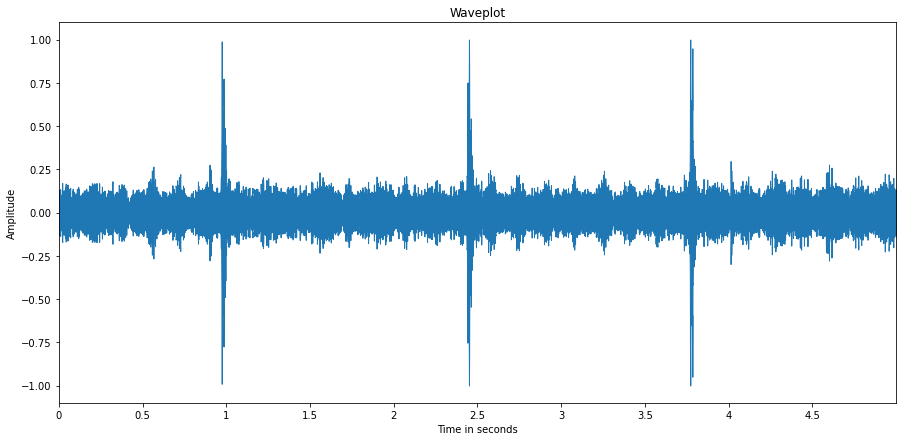

In [59]:
from librosa import display

plt.figure(figsize=(15,7))
librosa.display.waveplot(y=samples, sr=sampling_rate)
plt.title('Waveplot')
plt.xlabel('Time in seconds')
plt.ylabel('Amplitude')
plt.savefig('signal.jpg')

In [60]:
y, sr = librosa.load(audiofile)
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
print(tempo)

172.265625


In [61]:
exportfile = 'spectogram.jpg'
durationsecs = 7
hoplength = 512
samprate = 44100
nfft = 2048

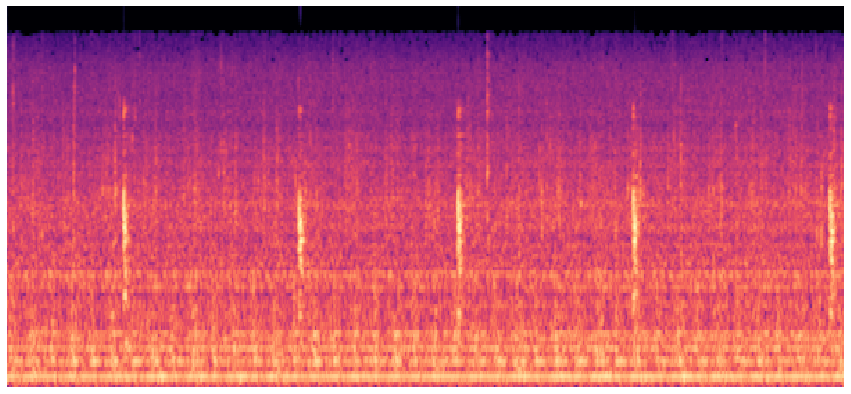

In [62]:
plt.figure(figsize=(15, 7))

y, sr = librosa.load(audiofile,  sr = None, mono = True, offset = 0.0, duration = durationsecs)
plt.ioff()
        
mel_signal = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=hoplength, n_fft=nfft)
spectrogram = np.abs(mel_signal)
power_to_db = librosa.power_to_db(spectrogram, ref=np.max)
librosa.display.specshow(power_to_db, sr=sr, x_axis='time', y_axis='mel', cmap='magma', hop_length=hoplength)
       
plt.axis('off')
plt.savefig(exportfile, dpi = 300)
#plt.close('all')

In [63]:
%%time
input_data = open(exportfile, 'rb').read()
# Set the content type
headers = {'Content-Type': 'application/json'}
# If authentication is enabled, set the authorization header
headers['Authorization'] = f'Bearer {key}'
# Make the request and display the response
resp = requests.post(scoring_uri, input_data, headers=headers)
print(resp.text)

{"filename": "/tmp/tmp_0o2rb1u", "probs": [0.7759099006652832, 0.224090114235878], "labels": ["KO", "OK"]}

CPU times: user 6.99 ms, sys: 768 µs, total: 7.76 ms
Wall time: 412 ms


In [64]:
predictions = json.loads(resp.text) # Loadind the predictions from the computer vision model    
predictions

{'filename': '/tmp/tmp_0o2rb1u',
 'probs': [0.7759099006652832, 0.224090114235878],
 'labels': ['KO', 'OK']}

In [65]:
probs = predictions['probs']
labels = predictions['labels']

if probs[0] >= probs[1]:
    max = 0
elif probs[0] < probs[1]:
    max = 1
    
if labels[max] == 'KO':
    msg = '[Alert] There is a sound anomaly with confidence of ' + str(round(probs[max] * 100, 2)) + '%'
    print('\033[1;31;91m', msg)

if labels[max] == 'OK':
    msg = '[OK] There is no sound anomaly with confidence of ' + str(round(probs[max] * 100, 2)) + '%'
    print('\033[1;31;34m', msg)

 [Alert] There is a sound anomaly with confidence of 77.59%


In [66]:
gauge_report(probs[max], labels[max])

## 2. Test 2

In [21]:
audiofile = 'test/machine_OK_57.wav'

In [22]:
samples, sampling_rate = librosa.load(audiofile, sr = None, mono = True, offset = 0.0, duration = 5)
len(samples), sampling_rate
duration = len(samples) / sampling_rate
print("Samping rate:", sampling_rate)

Samping rate: 44100


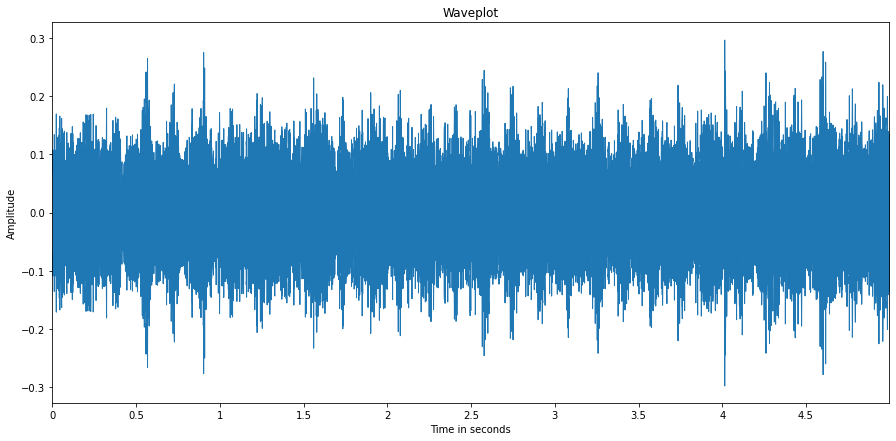

In [23]:
from librosa import display

plt.figure(figsize=(15,7))
librosa.display.waveplot(y=samples, sr=sampling_rate)
plt.title('Waveplot')
plt.xlabel('Time in seconds')
plt.ylabel('Amplitude')
plt.savefig('signal.jpg')

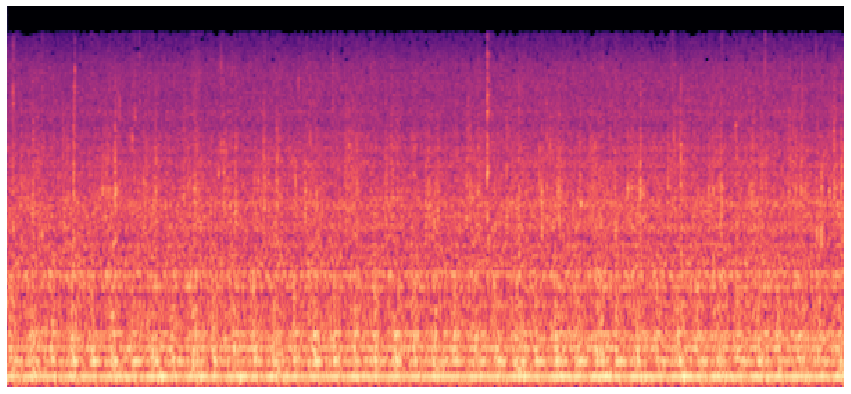

In [24]:
plt.figure(figsize=(15, 7))

y, sr = librosa.load(audiofile,  sr = None, mono = True, offset = 0.0, duration = durationsecs)
plt.ioff()
        
mel_signal = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=hoplength, n_fft=nfft)
spectrogram = np.abs(mel_signal)
power_to_db = librosa.power_to_db(spectrogram, ref=np.max)
librosa.display.specshow(power_to_db, sr=sr, x_axis='time', y_axis='mel', cmap='magma', hop_length=hoplength)
       
plt.axis('off')
plt.savefig(exportfile, dpi = 300)
#plt.close('all')

In [25]:
%%time
input_data = open(exportfile, 'rb').read()
# Set the content type
headers = {'Content-Type': 'application/json'}
# If authentication is enabled, set the authorization header
headers['Authorization'] = f'Bearer {key}'
# Make the request and display the response
resp = requests.post(scoring_uri, input_data, headers=headers)
print(resp.text)

{"filename": "/tmp/tmp8o0s8il6", "probs": [0.28656619787216187, 0.7134338617324829], "labels": ["KO", "OK"]}

CPU times: user 2.46 ms, sys: 4.61 ms, total: 7.07 ms
Wall time: 375 ms


In [26]:
predictions = json.loads(resp.text) # Loadind the predictions from the computer vision model    
predictions

{'filename': '/tmp/tmp8o0s8il6',
 'probs': [0.28656619787216187, 0.7134338617324829],
 'labels': ['KO', 'OK']}

In [27]:
probs = predictions['probs']
labels = predictions['labels']

if probs[0] >= probs[1]:
    max = 0
elif probs[0] < probs[1]:
    max = 1
    
if labels[max] == 'KO':
    msg = '[Alert] There is a sound anomaly with confidence of ' + str(round(probs[max] * 100, 2)) + '%'
    print('\033[1;31;91m', msg)

if labels[max] == 'OK':
    msg = '[OK] There is no sound anomaly with confidence of ' + str(round(probs[max] * 100, 2)) + '%'
    print('\033[1;31;34m', msg)


 [OK] There is no sound anomaly with confidence of 71.34%


In [55]:
gauge_report(probs[max], labels[max])

> End of notebook